In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset

from torch.autograd import Variable
from utils import create_dataloader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

### Creating config object (argparse workaround)

In [5]:
class Config:
    pass

config = Config()
config.mnist_path = '.'
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

### Create dataloder

In [54]:
dataloader = create_dataloader(config)

In [55]:
len(dataloader)

3750

In [56]:
for images, cat in dataloader:
    break

In [57]:
images.size()

torch.Size([16, 1, 28, 28])

In [58]:
28*28

784

### Create generator and discriminator

In [6]:
class Generator(nn.Module):
    def __init__(self, out=28*28, noise_size=config.noise_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, out),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self, inp=28*28):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(inp, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [60]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [61]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [4]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [62]:
fake_label = Variable(torch.FloatTensor(np.zeros((config.batch_size, 1))), requires_grad=False)
real_label = Variable(torch.FloatTensor(np.ones((config.batch_size, 1))), requires_grad=False)

### Задание

1) Имплементируйте GAN из статьи

2) Попробуйте LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### GAN

In [63]:
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input.data.copy_(images)
        output = discriminator(input)
        errD_x = criterion(output, label)
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                        iteration+1, 
                                                                        errD_x.data[0]+errD_z.data[0], 
                                                                        errG.data[0]))

Epoch:1 Iter: 100 errD: 0.19 errG: 2.74
Epoch:1 Iter: 200 errD: 0.08 errG: 4.17
Epoch:1 Iter: 300 errD: 0.35 errG: 4.08
Epoch:1 Iter: 400 errD: 0.38 errG: 3.83
Epoch:1 Iter: 500 errD: 0.55 errG: 2.02
Epoch:1 Iter: 600 errD: 0.28 errG: 2.85
Epoch:1 Iter: 700 errD: 0.19 errG: 2.77
Epoch:1 Iter: 800 errD: 0.11 errG: 3.16
Epoch:1 Iter: 900 errD: 0.14 errG: 2.80
Epoch:1 Iter: 1000 errD: 0.21 errG: 3.36
Epoch:1 Iter: 1100 errD: 0.08 errG: 3.05
Epoch:1 Iter: 1200 errD: 0.17 errG: 3.07
Epoch:1 Iter: 1300 errD: 0.09 errG: 3.02
Epoch:1 Iter: 1400 errD: 0.17 errG: 2.60
Epoch:1 Iter: 1500 errD: 0.15 errG: 2.30
Epoch:1 Iter: 1600 errD: 0.20 errG: 2.47
Epoch:1 Iter: 1700 errD: 0.15 errG: 2.54
Epoch:1 Iter: 1800 errD: 0.21 errG: 2.33
Epoch:1 Iter: 1900 errD: 0.10 errG: 2.71
Epoch:1 Iter: 2000 errD: 0.12 errG: 2.42
Epoch:1 Iter: 2100 errD: 0.13 errG: 2.78
Epoch:1 Iter: 2200 errD: 0.32 errG: 2.50
Epoch:1 Iter: 2300 errD: 0.21 errG: 3.40
Epoch:1 Iter: 2400 errD: 0.09 errG: 3.06
Epoch:1 Iter: 2500 errD: 

Epoch:6 Iter: 1800 errD: 0.37 errG: 5.69
Epoch:6 Iter: 1900 errD: 0.14 errG: 4.81
Epoch:6 Iter: 2000 errD: 0.07 errG: 5.33
Epoch:6 Iter: 2100 errD: 0.27 errG: 5.22
Epoch:6 Iter: 2200 errD: 0.05 errG: 4.33
Epoch:6 Iter: 2300 errD: 0.10 errG: 4.89
Epoch:6 Iter: 2400 errD: 0.18 errG: 4.95
Epoch:6 Iter: 2500 errD: 0.11 errG: 4.74
Epoch:6 Iter: 2600 errD: 0.07 errG: 4.90
Epoch:6 Iter: 2700 errD: 0.48 errG: 3.95
Epoch:6 Iter: 2800 errD: 0.10 errG: 5.21
Epoch:6 Iter: 2900 errD: 0.29 errG: 4.78
Epoch:6 Iter: 3000 errD: 0.23 errG: 3.77
Epoch:6 Iter: 3100 errD: 0.03 errG: 6.55
Epoch:6 Iter: 3200 errD: 0.03 errG: 5.93
Epoch:6 Iter: 3300 errD: 0.26 errG: 3.91
Epoch:6 Iter: 3400 errD: 0.49 errG: 4.55
Epoch:6 Iter: 3500 errD: 0.14 errG: 4.75
Epoch:6 Iter: 3600 errD: 0.03 errG: 5.51
Epoch:6 Iter: 3700 errD: 0.26 errG: 4.66
Epoch:7 Iter: 100 errD: 0.04 errG: 5.73
Epoch:7 Iter: 200 errD: 0.31 errG: 3.42
Epoch:7 Iter: 300 errD: 0.04 errG: 4.76
Epoch:7 Iter: 400 errD: 0.18 errG: 3.97
Epoch:7 Iter: 500 er

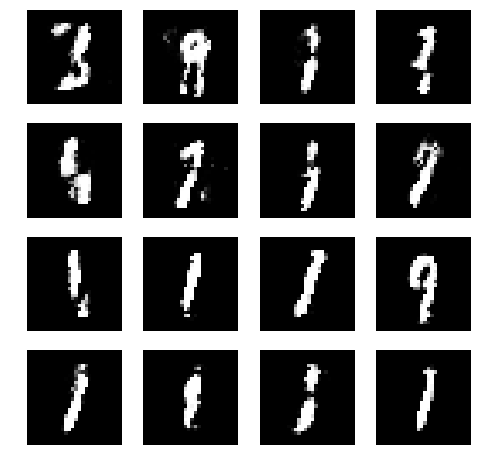

In [103]:
res = generator(noise).data
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(res[i].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
# plt.imshow(lsgenerator(noise).data[0].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)

### LSGAN

In [69]:
lsgenerator = Generator()
lsdiscriminator = Discriminator()

In [71]:
optim_LSG = optim.Adam(params=lsgenerator.parameters(), lr=0.0001)
optim_LSD = optim.Adam(params=lsdiscriminator.parameters(), lr=0.0001)

criterionLS = nn.MSELoss()

In [72]:
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        
        X = Variable(images.view(images.size(0), -1))
        noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
        
        generated = lsdiscriminator(lsgenerator(noise).detach())
        real = lsdiscriminator(X)
        
        errD = 0.5 * (criterionLS(real, real_label) + criterionLS(generated, fake_label))
        
        lsdiscriminator.zero_grad()
        errD.backward()
        optim_LSD.step()
        
        generated = lsdiscriminator(lsgenerator(noise))
        errG = 0.5 * criterionLS(generated, real_label)
        
        lsgenerator.zero_grad()
        errG.backward()
        optim_LSG.step()
    
    
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD: {:.2f} errG: {:.2f}'.format(epoch+1, iteration+1, 
                                                                       errD.data[0], errG.data[0]))

Epoch:1 Iter: 100 errD: 0.02 errG: 0.41
Epoch:1 Iter: 200 errD: 0.01 errG: 0.46
Epoch:1 Iter: 300 errD: 0.02 errG: 0.45
Epoch:1 Iter: 400 errD: 0.04 errG: 0.47
Epoch:1 Iter: 500 errD: 0.07 errG: 0.43
Epoch:1 Iter: 600 errD: 0.01 errG: 0.44
Epoch:1 Iter: 700 errD: 0.02 errG: 0.46
Epoch:1 Iter: 800 errD: 0.01 errG: 0.42
Epoch:1 Iter: 900 errD: 0.01 errG: 0.46
Epoch:1 Iter: 1000 errD: 0.02 errG: 0.45
Epoch:1 Iter: 1100 errD: 0.01 errG: 0.45
Epoch:1 Iter: 1200 errD: 0.01 errG: 0.42
Epoch:1 Iter: 1300 errD: 0.03 errG: 0.37
Epoch:1 Iter: 1400 errD: 0.06 errG: 0.37
Epoch:1 Iter: 1500 errD: 0.03 errG: 0.37
Epoch:1 Iter: 1600 errD: 0.02 errG: 0.35
Epoch:1 Iter: 1700 errD: 0.05 errG: 0.39
Epoch:1 Iter: 1800 errD: 0.03 errG: 0.31
Epoch:1 Iter: 1900 errD: 0.06 errG: 0.36
Epoch:1 Iter: 2000 errD: 0.01 errG: 0.41
Epoch:1 Iter: 2100 errD: 0.00 errG: 0.43
Epoch:1 Iter: 2200 errD: 0.01 errG: 0.42
Epoch:1 Iter: 2300 errD: 0.02 errG: 0.38
Epoch:1 Iter: 2400 errD: 0.01 errG: 0.42
Epoch:1 Iter: 2500 errD: 

Epoch:6 Iter: 1800 errD: 0.05 errG: 0.45
Epoch:6 Iter: 1900 errD: 0.01 errG: 0.45
Epoch:6 Iter: 2000 errD: 0.03 errG: 0.45
Epoch:6 Iter: 2100 errD: 0.02 errG: 0.44
Epoch:6 Iter: 2200 errD: 0.01 errG: 0.44
Epoch:6 Iter: 2300 errD: 0.08 errG: 0.48
Epoch:6 Iter: 2400 errD: 0.02 errG: 0.48
Epoch:6 Iter: 2500 errD: 0.01 errG: 0.44
Epoch:6 Iter: 2600 errD: 0.03 errG: 0.41
Epoch:6 Iter: 2700 errD: 0.04 errG: 0.43
Epoch:6 Iter: 2800 errD: 0.06 errG: 0.46
Epoch:6 Iter: 2900 errD: 0.04 errG: 0.43
Epoch:6 Iter: 3000 errD: 0.01 errG: 0.45
Epoch:6 Iter: 3100 errD: 0.00 errG: 0.48
Epoch:6 Iter: 3200 errD: 0.02 errG: 0.44
Epoch:6 Iter: 3300 errD: 0.02 errG: 0.44
Epoch:6 Iter: 3400 errD: 0.02 errG: 0.47
Epoch:6 Iter: 3500 errD: 0.02 errG: 0.46
Epoch:6 Iter: 3600 errD: 0.02 errG: 0.44
Epoch:6 Iter: 3700 errD: 0.01 errG: 0.46
Epoch:7 Iter: 100 errD: 0.01 errG: 0.49
Epoch:7 Iter: 200 errD: 0.03 errG: 0.47
Epoch:7 Iter: 300 errD: 0.01 errG: 0.46
Epoch:7 Iter: 400 errD: 0.08 errG: 0.39
Epoch:7 Iter: 500 er

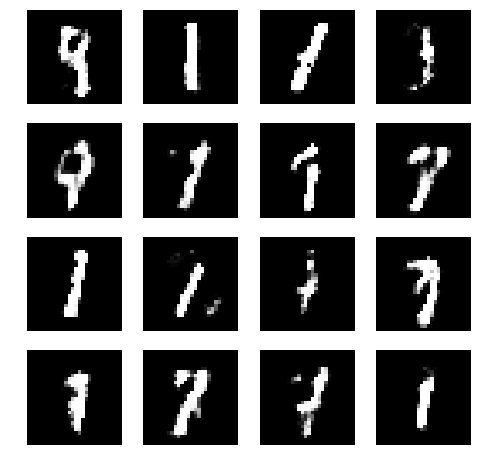

In [102]:
res = lsgenerator(noise).data
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(res[i].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### FaceDataset

In [64]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, max_size=-1, transform=None):
        self.images = os.listdir(root_dir)
        
        if max_size != -1:
            self.images = self.images[0:max_size]
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = io.imread(img_name).reshape(-1) / 255.0

        if self.transform:
            image = self.transform(image)

        return image

In [65]:
faces_dataset = FaceDataset('./img_align_celeba/', max_size=10000)
faces_dataloader = DataLoader(faces_dataset, batch_size=16)

In [69]:
generatorIM = Generator(out=116412).cuda()
discriminatorIM = Discriminator(inp=116412).cuda()

In [70]:
optim_GIM = optim.Adam(params=generatorIM.parameters(), lr=0.0001)
optim_DIM = optim.Adam(params=discriminatorIM.parameters(), lr=0.0001)

criterionIM = nn.BCELoss().cuda()

In [71]:
fake_label_IM = Variable(torch.FloatTensor(np.zeros((16, 1))), requires_grad=False).cuda()
real_label_IM = Variable(torch.FloatTensor(np.ones((16, 1))), requires_grad=False).cuda()

In [72]:
for epoch in range(config.num_epochs):
    for iteration, images in enumerate(faces_dataloader):
        
        X = Variable(images.view(images.size(0), -1).float()).cuda()
        noise = Variable(torch.FloatTensor(images.size(0), config.noise_size).normal_(0, 1)).cuda()
        
        generated = discriminatorIM(generatorIM(noise).detach())
        real = discriminatorIM(X)
        
        errD = (criterionIM(real, real_label_IM) + criterionIM(generated, fake_label_IM))
        
        discriminatorIM.zero_grad()
        errD.backward()
        optim_DIM.step()
        
        generated = discriminatorIM(generatorIM(noise))
        errG = criterionIM(generated, real_label_IM)
        
        generatorIM.zero_grad()
        errG.backward()
        optim_GIM.step()
    
    
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD: {:.2f} errG: {:.2f}'.format(epoch+1, iteration+1, 
                                                                       errD.data[0], errG.data[0]))

Epoch:1 Iter: 100 errD: 0.57 errG: 1.61
Epoch:1 Iter: 200 errD: 0.49 errG: 2.32
Epoch:1 Iter: 300 errD: 0.54 errG: 2.27
Epoch:1 Iter: 400 errD: 0.51 errG: 2.15
Epoch:1 Iter: 500 errD: 0.18 errG: 2.64
Epoch:1 Iter: 600 errD: 0.54 errG: 3.36
Epoch:2 Iter: 100 errD: 0.41 errG: 1.73
Epoch:2 Iter: 200 errD: 0.38 errG: 2.97
Epoch:2 Iter: 300 errD: 0.50 errG: 3.72
Epoch:2 Iter: 400 errD: 0.24 errG: 3.55
Epoch:2 Iter: 500 errD: 0.27 errG: 1.96
Epoch:2 Iter: 600 errD: 0.24 errG: 3.71
Epoch:3 Iter: 100 errD: 0.46 errG: 1.66
Epoch:3 Iter: 200 errD: 0.24 errG: 2.97
Epoch:3 Iter: 300 errD: 0.73 errG: 4.05
Epoch:3 Iter: 400 errD: 1.01 errG: 1.82
Epoch:3 Iter: 500 errD: 0.36 errG: 1.73
Epoch:3 Iter: 600 errD: 0.19 errG: 2.65
Epoch:4 Iter: 100 errD: 0.91 errG: 1.09
Epoch:4 Iter: 200 errD: 0.67 errG: 3.50
Epoch:4 Iter: 300 errD: 0.35 errG: 3.14
Epoch:4 Iter: 400 errD: 0.62 errG: 1.92
Epoch:4 Iter: 500 errD: 1.03 errG: 0.72
Epoch:4 Iter: 600 errD: 0.37 errG: 2.82
Epoch:5 Iter: 100 errD: 0.66 errG: 1.76


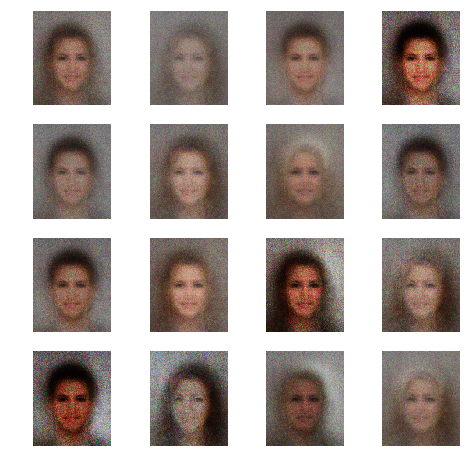

In [73]:
res = generatorIM(noise).cpu().data
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(res[i].numpy().reshape(218, 178, 3))
    plt.axis('off')

In [80]:
generatorIM_LS = Generator(out=116412).cuda()
discriminatorIM_LS = Discriminator(inp=116412).cuda()

In [81]:
optim_GIM_LS = optim.Adam(params=generatorIM_LS.parameters(), lr=0.0001)
optim_DIM_LS = optim.Adam(params=discriminatorIM_LS.parameters(), lr=0.0001)

criterionIM_LS = nn.MSELoss().cuda()

In [82]:
for epoch in range(config.num_epochs):
    for iteration, images in enumerate(faces_dataloader):
        
        X = Variable(images.view(images.size(0), -1).float()).cuda()
        noise = Variable(torch.FloatTensor(images.size(0), config.noise_size).normal_(0, 1)).cuda()
        
        generated = discriminatorIM_LS(generatorIM_LS(noise).detach())
        real = discriminatorIM_LS(X)
        
        errD = 0.5 * (criterionIM_LS(real, real_label_IM) + criterionIM_LS(generated, fake_label_IM))
        
        discriminatorIM_LS.zero_grad()
        errD.backward()
        optim_DIM_LS.step()
        
        generated = discriminatorIM_LS(generatorIM_LS(noise))
        errG = 0.5 * criterionIM_LS(generated, real_label_IM)
        
        generatorIM_LS.zero_grad()
        errG.backward()
        optim_GIM_LS.step()
    
    
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD: {:.2f} errG: {:.2f}'.format(epoch+1, iteration+1, 
                                                                       errD.data[0], errG.data[0]))

Epoch:1 Iter: 100 errD: 0.12 errG: 0.42
Epoch:1 Iter: 200 errD: 0.10 errG: 0.28
Epoch:1 Iter: 300 errD: 0.12 errG: 0.30
Epoch:1 Iter: 400 errD: 0.06 errG: 0.33
Epoch:1 Iter: 500 errD: 0.02 errG: 0.40
Epoch:1 Iter: 600 errD: 0.06 errG: 0.35
Epoch:2 Iter: 100 errD: 0.03 errG: 0.42
Epoch:2 Iter: 200 errD: 0.09 errG: 0.30
Epoch:2 Iter: 300 errD: 0.09 errG: 0.37
Epoch:2 Iter: 400 errD: 0.05 errG: 0.36
Epoch:2 Iter: 500 errD: 0.10 errG: 0.38
Epoch:2 Iter: 600 errD: 0.07 errG: 0.33
Epoch:3 Iter: 100 errD: 0.07 errG: 0.33
Epoch:3 Iter: 200 errD: 0.08 errG: 0.31
Epoch:3 Iter: 300 errD: 0.08 errG: 0.33
Epoch:3 Iter: 400 errD: 0.08 errG: 0.31
Epoch:3 Iter: 500 errD: 0.04 errG: 0.33
Epoch:3 Iter: 600 errD: 0.04 errG: 0.32
Epoch:4 Iter: 100 errD: 0.03 errG: 0.33
Epoch:4 Iter: 200 errD: 0.05 errG: 0.33
Epoch:4 Iter: 300 errD: 0.07 errG: 0.37
Epoch:4 Iter: 400 errD: 0.06 errG: 0.36
Epoch:4 Iter: 500 errD: 0.13 errG: 0.23
Epoch:4 Iter: 600 errD: 0.21 errG: 0.22
Epoch:5 Iter: 100 errD: 0.06 errG: 0.36


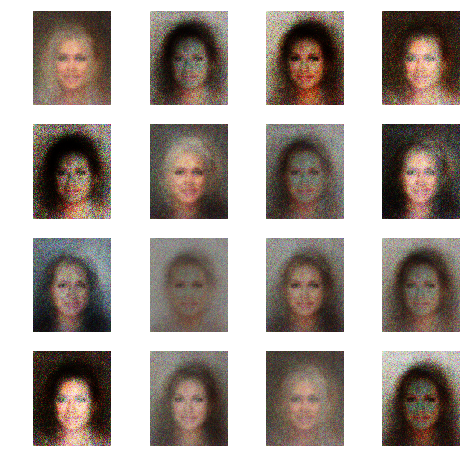

In [83]:
res = generatorIM_LS(noise).cpu().data
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(res[i].numpy().reshape(218, 178, 3))
    plt.axis('off')